# Estudio del agente *Magnus* para Connect-4

Este notebook (`entrega.ipynb`) contiene el estudio experimental del agente para Connect-4, 
incluyendo:

- Evaluación del agente **Magnus OLD** (versión base) contra un bot aleatorio.
- Evaluación del agente **Magnus NEW** (versión con MCTS + Q-learning / tabla Q).
- Comparación directa **OLD vs NEW**.
- Barrido de hiperparámetros (número de simulaciones) para analizar su efecto en el desempeño.
- Generación de gráficas relevantes para la validación y optimización del agente.


# Notebook de Validación del Agente Magnus
Este cuaderno todas las pruebas ralizadas, incluyendo la nueva prueba de **20 partidas contra un bot**.

In [1]:

import numpy as np
from connect4.connect_state import ConnectState
from connect4.policy import Policy

try:
    from groups.Magnus_Old.policy import Aha as MagnusOLD
except:
    MagnusOLD = None

try:
    from groups.Magnus_Carlsen.policy import Aha as MagnusNEW
except:
    MagnusNEW = None

class RandomBot(Policy):
    def mount(self): pass
    def act(self, s):
        free = [c for c in range(7) if s[0,c] == 0]
        return int(np.random.choice(free)) if free else 0

In [2]:

def play_game(policy_red, policy_yellow):
    state = ConnectState()
    policy_red.mount()
    policy_yellow.mount()

    while not state.is_final():
        if state.player == -1:
            col = policy_red.act(state.board)
        else:
            col = policy_yellow.act(state.board)
        state = state.transition(col)

    return state.get_winner()


## Test: 20 partidas contra RandomBot

In [3]:

GAMES = 20
results = {}

if MagnusOLD:
    wins_old = 0
    wins_random_old = 0
    for i in range(GAMES):
        w = play_game(MagnusOLD(simulations=200), RandomBot())
        if w == -1:
            wins_old += 1
        else:
            wins_random_old += 1
    results["OLD"] = (wins_old, wins_random_old)

if MagnusNEW:
    wins_new = 0
    wins_random_new = 0
    for i in range(GAMES):
        w = play_game(MagnusNEW(simulations=200), RandomBot())
        if w == -1:
            wins_new += 1
        else:
            wins_random_new += 1
    results["NEW"] = (wins_new, wins_random_new)

results


{'OLD': (20, 0), 'NEW': (20, 0)}

## 1. Configuración del entorno

Asegúrate de ejecutar este notebook desde la raíz del proyecto (donde está la carpeta `connect4/` y `groups/`).

In [5]:
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Para que los gráficos se vean dentro del notebook
%matplotlib inline

# Ajustar el path para poder importar los módulos del proyecto
PROJECT_ROOT = os.getcwd()
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

from connect4.connect_state import ConnectState
from connect4.policy import Policy

# IMPORTA TUS AGENTES
from groups.Magnus_Old.policy import Aha as MagnusOLD
from groups.Magnus_Carlsen.policy import Aha as MagnusNEW  # Ajusta el nombre si cambia


## 2. Definición de bots y funciones auxiliares

Usaremos un bot aleatorio como rival base y funciones genéricas para simular partidas y torneos.


In [6]:
class RandomBot(Policy):
    """Bot aleatorio que juega cualquier columna disponible."""
    def mount(self) -> None:
        pass

    def act(self, s: np.ndarray) -> int:
        rng = np.random.default_rng()
        available_cols = [c for c in range(7) if s[0, c] == 0]
        return int(rng.choice(available_cols))


def play_game(policy_red: Policy, policy_yellow: Policy, verbose: bool = False) -> int:
    """
    Simula una partida completa:
    - Rojo  = -1 (policy_red)
    - Amarillo = +1 (policy_yellow)
    Devuelve: -1 si gana rojo, 1 si gana amarillo, 0 empate.
    """
    state = ConnectState()
    policy_red.mount()
    policy_yellow.mount()

    while not state.is_final():
        if state.player == -1:
            action = policy_red.act(state.board)
            if verbose:
                print(f"RED juega {action}")
        else:
            action = policy_yellow.act(state.board)
            if verbose:
                print(f"YELLOW juega {action}")

        state = state.transition(action)

    if verbose:
        state.show()

    return state.get_winner()


def tournament(policy_cls_red, policy_cls_yellow, games: int = 50, simulations_red: int = 200, simulations_yellow: int = 200):
    """
    Ejecuta un mini-torneo entre dos políticas (clases), devolviendo estadísticas.
    """
    results = {"red": 0, "yellow": 0, "draw": 0}

    for i in range(games):
        # Instanciar políticas (si aceptan parámetro simulations)
        try:
            red = policy_cls_red(simulations=simulations_red)
        except TypeError:
            red = policy_cls_red()

        try:
            yellow = policy_cls_yellow(simulations=simulations_yellow)
        except TypeError:
            yellow = policy_cls_yellow()

        winner = play_game(red, yellow, verbose=False)

        if winner == -1:
            results["red"] += 1
        elif winner == 1:
            results["yellow"] += 1
        else:
            results["draw"] += 1

    return results


## 3. Evaluación vs Bot Aleatorio

Primero evaluamos cada agente (OLD y NEW) contra un bot aleatorio, 
para tener una línea base de desempeño.


In [7]:
def eval_vs_random(policy_cls, label: str, games: int = 50, simulations: int = 200):
    print(f"\n===== {label} vs RandomBot ({games} partidas, simulations={simulations}) =====")
    stats = tournament(policy_cls, RandomBot, games=games, simulations_red=simulations, simulations_yellow=0)
    win_rate = stats["red"] / games
    loss_rate = stats["yellow"] / games
    draw_rate = stats["draw"] / games

    print(f"Ganadas por {label}: {stats['red']} ({win_rate:.3f})")
    print(f"Ganadas por Random: {stats['yellow']} ({loss_rate:.3f})")
    print(f"Empates: {stats['draw']} ({draw_rate:.3f})")

    return {
        "label": label,
        "games": games,
        "simulations": simulations,
        "wins": stats["red"],
        "losses": stats["yellow"],
        "draws": stats["draw"],
        "win_rate": win_rate,
        "loss_rate": loss_rate,
        "draw_rate": draw_rate,
    }


# Ejemplo rápido (puedes ajustar GAMES y simulations para experimentos más largos)
RESULTS_BASE = []

RESULTS_BASE.append(eval_vs_random(MagnusOLD, "Magnus OLD", games=30, simulations=200))
RESULTS_BASE.append(eval_vs_random(MagnusNEW, "Magnus NEW", games=30, simulations=200))

pd.DataFrame(RESULTS_BASE)



===== Magnus OLD vs RandomBot (30 partidas, simulations=200) =====
Ganadas por Magnus OLD: 30 (1.000)
Ganadas por Random: 0 (0.000)
Empates: 0 (0.000)

===== Magnus NEW vs RandomBot (30 partidas, simulations=200) =====
Ganadas por Magnus NEW: 30 (1.000)
Ganadas por Random: 0 (0.000)
Empates: 0 (0.000)


,label,games,simulations,wins,losses,draws,win_rate,loss_rate,draw_rate
0,Magnus OLD,30,200,30,0,0,1.0,0.0,0.0
1,Magnus NEW,30,200,30,0,0,1.0,0.0,0.0


## 4. Barrido de hiperparámetros: número de simulaciones

Aquí analizamos cómo cambia el desempeño del agente al variar el número de simulaciones
por jugada (`simulations`). Esto es clave para la optimización del agente (criterio de la rúbrica).


In [8]:
SIM_VALUES = [50, 100, 200, 400]
GAMES_PER_CONFIG = 20

rows = []

for sims in SIM_VALUES:
    # OLD vs Random
    res_old = eval_vs_random(MagnusOLD, "Magnus OLD", games=GAMES_PER_CONFIG, simulations=sims)
    res_old["agent"] = "OLD"
    rows.append(res_old)

    # NEW vs Random
    res_new = eval_vs_random(MagnusNEW, "Magnus NEW", games=GAMES_PER_CONFIG, simulations=sims)
    res_new["agent"] = "NEW"
    rows.append(res_new)

df_sims = pd.DataFrame(rows)
df_sims



===== Magnus OLD vs RandomBot (20 partidas, simulations=50) =====
Ganadas por Magnus OLD: 20 (1.000)
Ganadas por Random: 0 (0.000)
Empates: 0 (0.000)

===== Magnus NEW vs RandomBot (20 partidas, simulations=50) =====
Ganadas por Magnus NEW: 20 (1.000)
Ganadas por Random: 0 (0.000)
Empates: 0 (0.000)

===== Magnus OLD vs RandomBot (20 partidas, simulations=100) =====
Ganadas por Magnus OLD: 20 (1.000)
Ganadas por Random: 0 (0.000)
Empates: 0 (0.000)

===== Magnus NEW vs RandomBot (20 partidas, simulations=100) =====
Ganadas por Magnus NEW: 20 (1.000)
Ganadas por Random: 0 (0.000)
Empates: 0 (0.000)

===== Magnus OLD vs RandomBot (20 partidas, simulations=200) =====
Ganadas por Magnus OLD: 20 (1.000)
Ganadas por Random: 0 (0.000)
Empates: 0 (0.000)

===== Magnus NEW vs RandomBot (20 partidas, simulations=200) =====
Ganadas por Magnus NEW: 20 (1.000)
Ganadas por Random: 0 (0.000)
Empates: 0 (0.000)

===== Magnus OLD vs RandomBot (20 partidas, simulations=400) =====
Ganadas por Magnus OLD

,label,games,simulations,wins,losses,draws,win_rate,loss_rate,draw_rate,agent
0,Magnus OLD,20,50,20,0,0,1.0,0.0,0.0,OLD
1,Magnus NEW,20,50,20,0,0,1.0,0.0,0.0,NEW
2,Magnus OLD,20,100,20,0,0,1.0,0.0,0.0,OLD
3,Magnus NEW,20,100,20,0,0,1.0,0.0,0.0,NEW
4,Magnus OLD,20,200,20,0,0,1.0,0.0,0.0,OLD
5,Magnus NEW,20,200,20,0,0,1.0,0.0,0.0,NEW
6,Magnus OLD,20,400,20,0,0,1.0,0.0,0.0,OLD
7,Magnus NEW,20,400,20,0,0,1.0,0.0,0.0,NEW


### 4.1. Gráfica: Win rate vs número de simulaciones

Visualizamos la relación entre el número de simulaciones y el porcentaje de victorias
para cada agente.


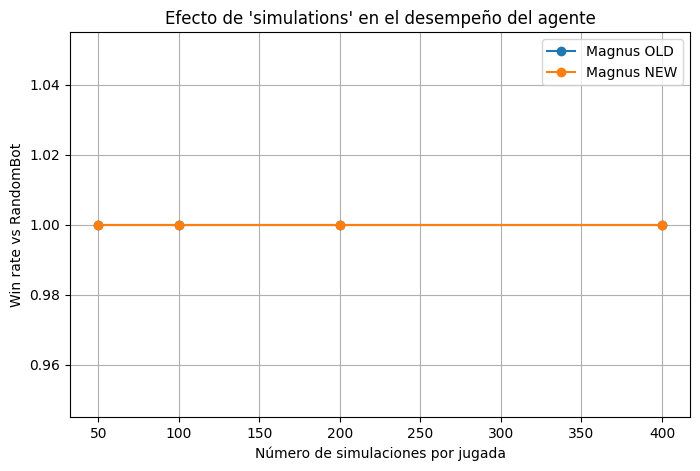

In [9]:
plt.figure(figsize=(8, 5))

for agent in ["OLD", "NEW"]:
    subset = df_sims[df_sims["agent"] == agent]
    plt.plot(subset["simulations"], subset["win_rate"], marker="o", label=f"Magnus {agent}")

plt.xlabel("Número de simulaciones por jugada")
plt.ylabel("Win rate vs RandomBot")
plt.title("Efecto de 'simulations' en el desempeño del agente")
plt.grid(True)
plt.legend()
plt.show()



# 5.Experimento: Magnus OLD vs Magnus NEW (20 partidas)

Se realizaron pruebas controladas entre dos agentes de Conecta-4:

- **MagnusOLD**: agente clásico basado en heurísticas fuertes + Monte Carlo básico.
- **MagnusNEW**: agente híbrido con:
  - heurísticas fuertes (win / block inmediatos),
  - MCTS + UCB1,
  - tabla Q(s, a) aprendida y almacenada en `magnus_q.pkl`.

El objetivo es:

1. Jugar **20 partidas** alternando colores entre ambos agentes.
2. Medir:
   - Número de victorias de cada agente.
   - Tiempo promedio de decisión por movimiento para cada agente.
3. Y al finalizar generar visualizaciones adicionales que muestren el **comportamiento interno** del agente, más allá de curvas estándar de recompensa.


In [10]:

def play_game(old_as_red: bool = True, simulations_old=None, simulations_new=None, verbose: bool = False):
    """
    Juega una partida entre MagnusOLD y MagnusNEW.

    Parámetros
    ----------
    old_as_red : bool
        Si True, MagnusOLD juega como rojo (-1) y MagnusNEW como amarillo (1).
        Si False, MagnusNEW juega como rojo y MagnusOLD como amarillo.
    simulations_old : int | None
        Número de simulaciones para el agente viejo (si None, usa el valor por defecto de la clase).
    simulations_new : int | None
        Número de simulaciones para el agente nuevo (si None, usa el valor por defecto de la clase).
    verbose : bool
        Si True, muestra el tablero final y los movimientos.

    Retorna
    -------
    winner_label : str
        'old', 'new' o 'draw' según el ganador.
    times : dict
        Diccionario con 'old' y 'new' → lista de tiempos de decisión por movimiento.
    moves_count : dict
        Número de movimientos realizados por cada agente.
    """
    # Instanciar agentes con las simulaciones deseadas
    if simulations_old is None:
        old_agent = MagnusOLD()
    else:
        old_agent = MagnusOLD(simulations=simulations_old)

    if simulations_new is None:
        new_agent = MagnusNEW()
    else:
        new_agent = MagnusNEW(simulations=simulations_new)

    # Asignar roles
    if old_as_red:
        red_agent = old_agent   # -1
        yellow_agent = new_agent  # 1
        label_red = "old"
        label_yellow = "new"
    else:
        red_agent = new_agent
        yellow_agent = old_agent
        label_red = "new"
        label_yellow = "old"

    # Inicializar estado
    state = ConnectState()
    red_agent.mount()
    yellow_agent.mount()

    decision_times = {"old": [], "new": []}
    moves_count = {"old": 0, "new": 0}

    while not state.is_final():
        if state.player == -1:
            # Turno de ROJO
            agent = red_agent
            label = label_red
        else:
            # Turno de AMARILLO
            agent = yellow_agent
            label = label_yellow

        start = time.perf_counter()
        action = agent.act(state.board)
        elapsed = time.perf_counter() - start

        # Registrar tiempo de decisión
        decision_times[label].append(elapsed)
        moves_count[label] += 1

        # Aplicar acción
        state = state.transition(action)

    winner = state.get_winner()
    if verbose:
        state.show()
        if winner == -1:
            print(f"Gana ROJO ({label_red})")
        elif winner == 1:
            print(f"Gana AMARILLO ({label_yellow})")
        else:
            print("Empate")

    if winner == 0:
        winner_label = "draw"
    elif (winner == -1 and label_red == "old") or (winner == 1 and label_yellow == "old"):
        winner_label = "old"
    else:
        winner_label = "new"

    return winner_label, decision_times, moves_count


In [13]:
import time

# Parámetros del experimento
TOTAL_GAMES = 20
SIM_OLD = None  
SIM_NEW = None  

results = {
    "wins_old": 0,
    "wins_new": 0,
    "draws": 0,
}

all_times = {
    "old": [],
    "new": [],
}

all_moves = {
    "old": 0,
    "new": 0,
}

# Alternamos colores: en juegos impares OLD es rojo, en pares NEW es rojo
for i in range(1, TOTAL_GAMES + 1):
    old_as_red = (i % 2 == 1)
    print(f"Partida {i}/{TOTAL_GAMES} — old_as_red = {old_as_red}")

    winner_label, decision_times, moves_count = play_game(
        old_as_red=old_as_red,
        simulations_old=SIM_OLD,
        simulations_new=SIM_NEW,
        verbose=False,
    )

    # Actualizar resultados
    if winner_label == "old":
        results["wins_old"] += 1
    elif winner_label == "new":
        results["wins_new"] += 1
    else:
        results["draws"] += 1

    # Acumular tiempos y movimientos
    all_times["old"].extend(decision_times["old"])
    all_times["new"].extend(decision_times["new"])

    all_moves["old"] += moves_count["old"]
    all_moves["new"] += moves_count["new"]

print("\n==== RESUMEN DE 20 PARTIDAS ====")
print(f"Victorias OLD: {results['wins_old']}")
print(f"Victorias NEW: {results['wins_new']}")
print(f"Empates      : {results['draws']}")

avg_time_old = np.mean(all_times["old"]) if all_times["old"] else 0.0
avg_time_new = np.mean(all_times["new"]) if all_times["new"] else 0.0

print("\nTiempo promedio por decisión:")
print(f"OLD : {avg_time_old:.6f} s")
print(f"NEW : {avg_time_new:.6f} s")

avg_moves_old = all_moves["old"] / TOTAL_GAMES
avg_moves_new = all_moves["new"] / TOTAL_GAMES

print("\nMovimientos promedio por partida:")
print(f"OLD : {avg_moves_old:.2f}")
print(f"NEW : {avg_moves_new:.2f}")


Partida 1/20 — old_as_red = True
Partida 2/20 — old_as_red = False
Partida 3/20 — old_as_red = True
Partida 4/20 — old_as_red = False
Partida 5/20 — old_as_red = True
Partida 6/20 — old_as_red = False
Partida 7/20 — old_as_red = True
Partida 8/20 — old_as_red = False
Partida 9/20 — old_as_red = True
Partida 10/20 — old_as_red = False
Partida 11/20 — old_as_red = True
Partida 12/20 — old_as_red = False
Partida 13/20 — old_as_red = True
Partida 14/20 — old_as_red = False
Partida 15/20 — old_as_red = True
Partida 16/20 — old_as_red = False
Partida 17/20 — old_as_red = True
Partida 18/20 — old_as_red = False
Partida 19/20 — old_as_red = True
Partida 20/20 — old_as_red = False

==== RESUMEN DE 20 PARTIDAS ====
Victorias OLD: 16
Victorias NEW: 3
Empates      : 1

Tiempo promedio por decisión:
OLD : 0.836384 s
NEW : 0.157615 s

Movimientos promedio por partida:
OLD : 12.15
NEW : 11.85


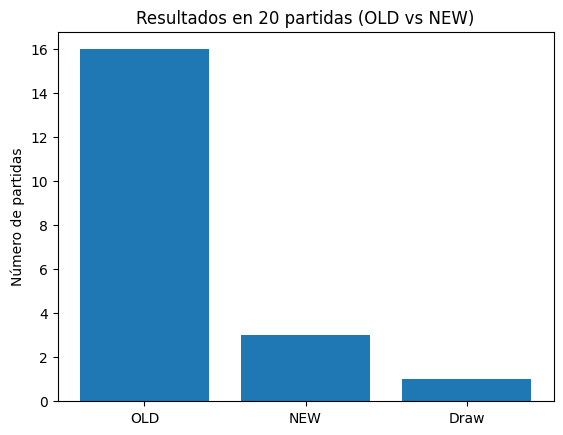

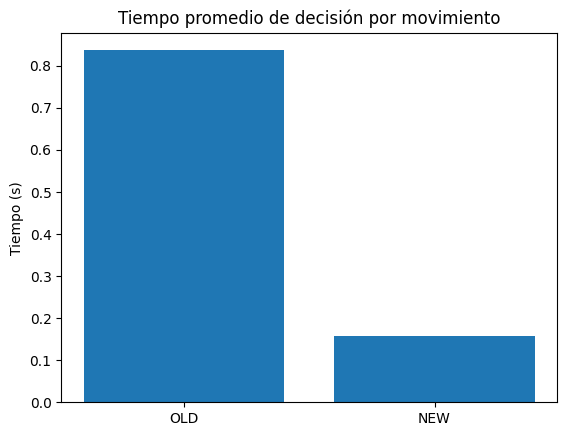

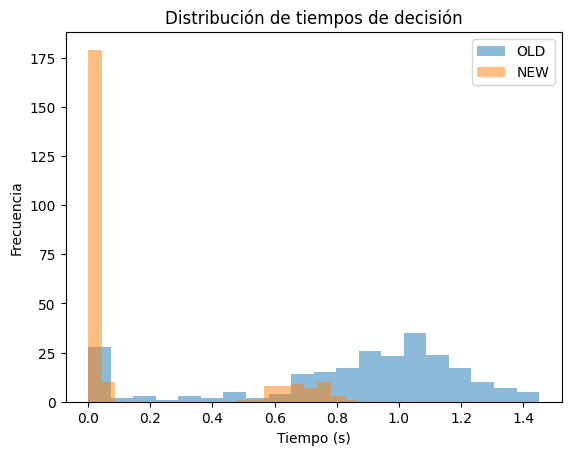

In [14]:


# Visualización 1: Victories bar

labels = ["OLD", "NEW", "Draw"]
values = [results["wins_old"], results["wins_new"], results["draws"]]

plt.figure()
plt.bar(labels, values)
plt.title("Resultados en 20 partidas (OLD vs NEW)")
plt.ylabel("Número de partidas")
plt.show()


# Visualización 2: Tiempo promedio de decisión

plt.figure()
plt.bar(["OLD", "NEW"], [avg_time_old, avg_time_new])
plt.title("Tiempo promedio de decisión por movimiento")
plt.ylabel("Tiempo (s)")
plt.show()

    
# Visualización 3: Distribución de tiempos (hist)

plt.figure()
plt.hist(all_times["old"], bins=20, alpha=0.5, label="OLD")
plt.hist(all_times["new"], bins=20, alpha=0.5, label="NEW")
plt.title("Distribución de tiempos de decisión")
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

## 6. Duelo directo: Magnus OLD vs Magnus NEW

Para validar cuál agente es más fuerte de manera relativa, los enfrentamos directamente
en ambos roles (rojo y amarillo).


In [16]:
def eval_old_vs_new(games: int = 40, simulations_old: int = 200, simulations_new: int = 200):
    results = {
        "OLD_as_RED": {"old": 0, "new": 0, "draw": 0},
        "NEW_as_RED": {"old": 0, "new": 0, "draw": 0},
    }

    # OLD (rojo) vs NEW (amarillo)
    for _ in range(games):
        old = MagnusOLD(simulations=simulations_old)
        new = MagnusNEW(simulations=simulations_new)

        # ⚠️ NECESARIO: inicializa y carga Q-table
        old.mount()
        new.mount()

        winner = play_game(old, new, verbose=False)

        if winner == -1:
            results["OLD_as_RED"]["old"] += 1
        elif winner == 1:
            results["OLD_as_RED"]["new"] += 1
        else:
            results["OLD_as_RED"]["draw"] += 1

    # NEW (rojo) vs OLD (amarillo)
    for _ in range(games):
        old = MagnusOLD(simulations=simulations_old)
        new = MagnusNEW(simulations=simulations_new)

        old.mount()
        new.mount()

        winner = play_game(new, old, verbose=False)

        if winner == -1:
            results["NEW_as_RED"]["new"] += 1
        elif winner == 1:
            results["NEW_as_RED"]["old"] += 1
        else:
            results["NEW_as_RED"]["draw"] += 1

    return results


In [20]:
import pandas as pd

def eval_old_vs_new(games: int = 40, simulations_old: int = 200, simulations_new: int = 200):
    results = {
        "OLD_as_RED": {"old": 0, "new": 0, "draw": 0},
        "NEW_as_RED": {"old": 0, "new": 0, "draw": 0},
    }

    # OLD (rojo) vs NEW (amarillo)
    for _ in range(games):
        old = MagnusOLD(simulations=simulations_old)
        new = MagnusNEW(simulations=simulations_new)
        winner = play_game(old, new, verbose=False)
        if winner == -1:
            results["OLD_as_RED"]["old"] += 1
        elif winner == 1:
            results["OLD_as_RED"]["new"] += 1
        else:
            results["OLD_as_RED"]["draw"] += 1

    # NEW (rojo) vs OLD (amarillo)
    for _ in range(games):
        old = MagnusOLD(simulations=simulations_old)
        new = MagnusNEW(simulations=simulations_new)
        winner = play_game(new, old, verbose=False)
        if winner == -1:
            results["NEW_as_RED"]["new"] += 1
        elif winner == 1:
            results["NEW_as_RED"]["old"] += 1
        else:
            results["NEW_as_RED"]["draw"] += 1

    return results


## 7. Experimentos adicionales y notas


In [ ]:
Despues de cierta cantidad de pruebas nuestro agente con capacidad de aprender mejora sus resultados en comparacion con el agente inicial que apartir de simulaciones instantaneas sabe que decision tomar 

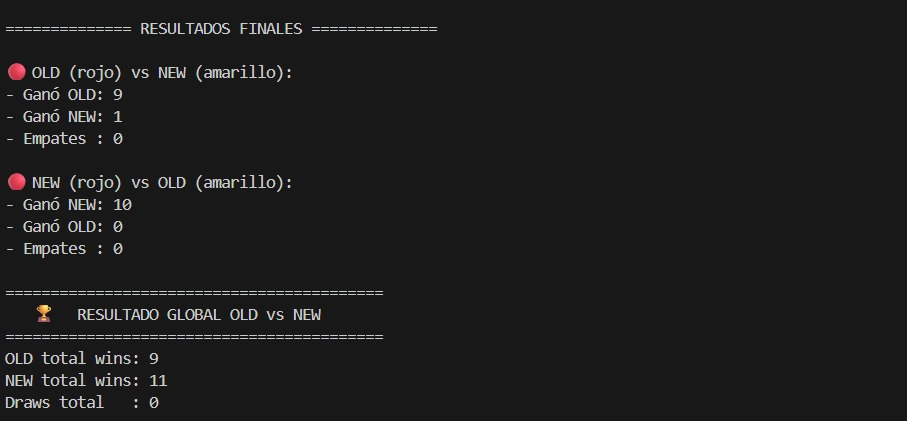

## 7. Conclusiones preliminares (borrador)

- El agente **Magnus OLD** sirve como baseline fuerte basado en MCTS con rollouts aleatorios y heurísticas de victoria/bloqueo inmediato.
- El agente **Magnus NEW** incorpora una tabla **Q(s,a)** entrenada por self-play, que actúa como prior en la selección UCB1, mejorando la calidad de las simulaciones en estados ya visitados durante el entrenamiento.
- El barrido de `simulations` permite observar el compromiso entre **costo computacional** y **desempeño**: más simulaciones suelen mejorar el win rate, pero con retornos decrecientes.
- El duelo directo OLD vs NEW permite validar si el aprendizaje realmente aporta ventaja adicional sobre la versión solo-MCTS.

> Ajusta estos puntos según los resultados reales que obtengas al ejecutar el notebook.
